In [1]:
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
import h5py
import pickle

from synthesizer.grid import Grid
from synthesizer.filters import FilterCollection as Filters
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.kernel_functions import Kernel
from synthesizer.particle import Stars, Gas, Galaxy

In [2]:
# set style
plt.style.use('../../matplotlibrc.txt')

In [3]:
h = 0.6774
Om0 = 0.3089
Ode0 = 0.6911
H0 = h * 100 
Ob0 = 0.0486

from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import LambdaCDM
from unyt import Myr

cosmo = LambdaCDM(Om0=Om0, Ode0=Ode0, H0=H0, Ob0=Ob0)
# cosmo = Planck13 

In [4]:

snap_z = 2.00202813925285
id = '145492'
filename = f'cutout_{id}.hdf5'

sub = pickle.load(open('sub.pck','rb'))

with h5py.File(filename) as f:

    f.visit(print)


Header
PartType0
PartType0/Coordinates
PartType0/GFM_Metallicity
PartType0/Masses
PartType0/SubfindHsml
PartType4
PartType4/Coordinates
PartType4/GFM_InitialMass
PartType4/GFM_Metallicity
PartType4/GFM_StellarFormationTime


In [5]:

with h5py.File(filename) as f:

    formation_scale_factor = f['PartType4']['GFM_StellarFormationTime'][()]
    formation_redshift = 1/formation_scale_factor - 1.0
    
    # only select star particles that make sense
    s = formation_redshift>=snap_z
    formation_redshift = formation_redshift[s]

    ages = (cosmo.age(z=snap_z)-cosmo.age(formation_redshift)).to('Myr').value * Myr


    x = f['PartType4']['Coordinates'][s,0] - sub['pos_x']
    y = f['PartType4']['Coordinates'][s,1] - sub['pos_y']
    z = f['PartType4']['Coordinates'][s,2] - sub['pos_z']

    stars = Stars(
        ages=ages,
        initial_masses=f['PartType4']['GFM_InitialMass'][s] * 1E10 / h,
        metallicities=f['PartType4']['GFM_Metallicity'][s],
        coordinates=np.array([x,y,z]).T/(1+snap_z)/h/1000,
        )

    x = f['PartType0']['Coordinates'][:,0] - sub['pos_x']
    y = f['PartType0']['Coordinates'][:,1] - sub['pos_y']
    z = f['PartType0']['Coordinates'][:,2] - sub['pos_z']

    gas = Gas(
        masses=f['PartType0']['Masses'][:] * 1E10 / h,
        metallicities=f['PartType0']['GFM_Metallicity'][:],
        smoothing_lengths=f['PartType0']['SubfindHsml'][:]/(1+snap_z)/h/1000,
        coordinates=np.array([x,y,z]).T/(1+snap_z)/h/1000,
        )

galaxy = Galaxy(stars=stars, gas=gas)


/Users/sw376/Dropbox/Research/projects/synthesizer-lines/venv/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


In [6]:
print(len(galaxy.gas._masses))
print(galaxy.gas._coordinates)

793943
[[ 1.62769810e-05  1.72569987e-04 -8.96167232e-05]
 [ 1.81968352e-05  2.04699812e-04 -5.82762721e-06]
 [ 2.84002607e-05  2.03775963e-04  5.10035742e-05]
 ...
 [ 9.31502832e-02 -4.10109421e-02 -2.55167922e-02]
 [-1.53137849e-02  1.59378538e-02 -6.08782552e-03]
 [ 5.10048932e-02  3.06615180e-02 -1.17219301e-02]]


In [7]:

kappa = 0.3
kernel = Kernel()
kernel.get_kernel()

galaxy.calculate_los_tau_v(kappa=kappa, kernel=kernel.get_kernel(), force_loop=True)

array([8.61491263e-01, 9.00579717e-01, 8.02747374e-01, ...,
       5.36033763e-06, 2.55226050e-06, 3.81426290e-04])

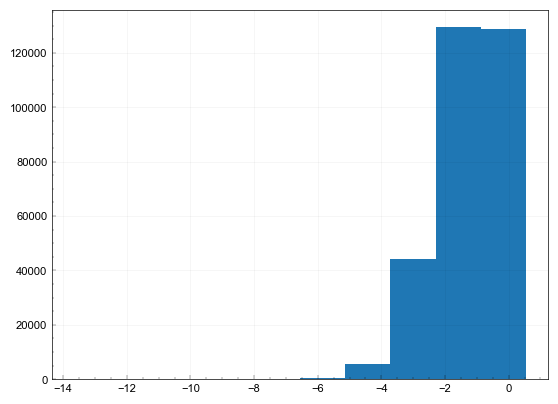

In [8]:

tauv = galaxy.stars.tau_v
tauv = tauv[tauv>0.0]

plt.hist(np.log10(tauv))
plt.show()

In [9]:
import pickle
pickle.dump(galaxy, open(f'galaxy_{id}.pck','wb'))